In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])
        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)            #
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

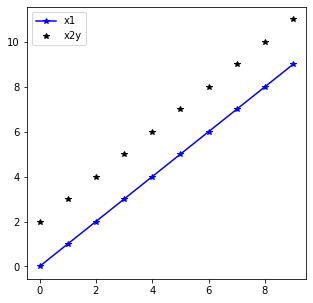

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

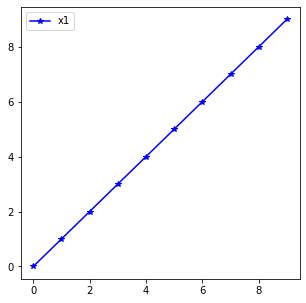

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [223]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self)}")
        return ax

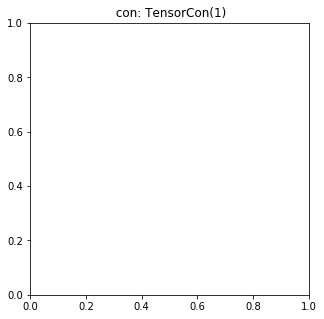

In [224]:
TensorCon(1).show()

## Utils

In [225]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [226]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [227]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [228]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [229]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= 2, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []
        self.ms = {}        

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, horizon=self.horizon, lookback=self.lookback, step=self.step , **kwargs)
        res.make_ids()
        return res

    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx,label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            # TODO make cat its own type
            r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['r']))
        return Tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
            if idx not in self.skipped:
#                 print(f"idx: {idx};y.std to high: {(y/x.std()).std()} > {self.max_std}")
                self.skipped.append(idx)
            raise SkipItemException()
              
        return r
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [230]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -1.212705 1 0.078148 2 2.943195 3 4.595902 4 5.907117 5 4.635859 6 4.699685 7 8.536893 8 9.910890 9 9.003732 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 2.427307 1 2.998172 2 5.232203 3 4.911647 4 4.648163 5 8.159838 6 7.617360 7 7.351713 8 8.475996 9 9.206978 10 13.909810 11 12.919183 dtype: float64,1.0,1


In [231]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [232]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 2, 11]), 'cat': torch.Size([3, 1]), 'con': torch.Size([3, 1]), 'y': torch.Size([3, 1, 11])}


(#2) ['ts_0','ts_1']

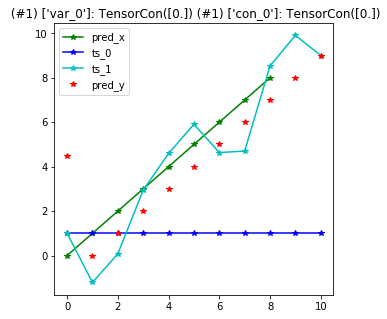

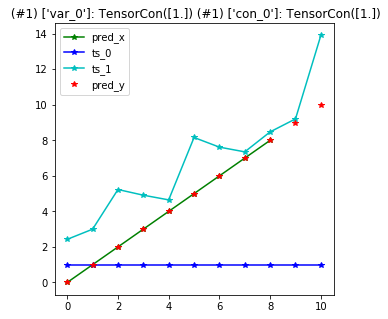

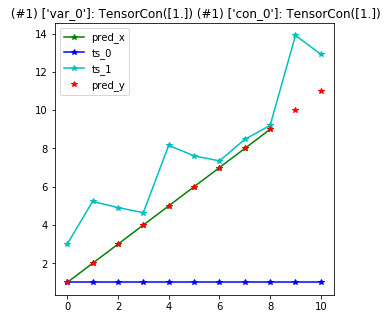

In [233]:
dl.show_batch(max_n=3)

In [234]:
# hide
# without cat or con
horizon,lookback = 2,9
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    dct = {k:v for k,v in zip(['pred','ts_0','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['ts_0'].shape, dct['y'].shape)
    test_eq(dct['pred'].shape[1:],(1,9))
    break


Need to pad 1/2 time series due to length.
{'pred': torch.Size([3, 1, 9]), 'ts_0': torch.Size([3, 1, 11]), 'y': torch.Size([3, 1, 11])}


# Intergration Example

In [235]:
from fastseq.data.external import *

In [236]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[-2.336607235788794, -2.429014826253815, -2.1679444592064643, -1.6092241510254115, -1.221477276645533, -0.8603028115084864, -0.14566374778384547, 0.5002064867510883, 0.8441110445143153, 1.370873564743626, 1.3953238975546811, 1.1882478183351821, 0.7699431975712179, 0.5058484535501034, 0.031391167137684556, -0.13492926750578638, -0.31035272140524756, -0.45679315997946707, -0.34398453507723853, -0.1284693362828983, -0.07877244022678731, 0.00028786870936968185, 0.06645413257034398, 0.3298602140758949, 0.48389678368767364, 0.6831691445579976, 0.6431152149386135, 0.6789352805613391, 0.820317523...","[[5.249698206535405, 4.77389795247997, 4.278104192349293, 4.020739651667786, 4.175438894615916, 4.76588446744239, 5.654488442580923, 6.589092541125261, 7.291053417672316, 7.5532313365943144, 7.312833616212483, 6.673058173762783, 5.865813993939026, 5.168893933704169, 4.807278660968162, 4.873915371318976, 5.2983115109620735, 5.874123501910635, 6.335755711340443, 6.456403307182986, 6.1322772491555275, 5.4226994112777325, 4.5315765141302, 3.736781819743076, 3.2926579537392087, 3.340504468978822, 3.8590698875244467, 4.67274865204142, 5.514520900992443, 6.121073263541199, 6.32602693495916, 6.117...",0,-0.560080
1,"[[-2.017725688771949, -2.1227563359429125, -2.0291463684637026, -1.6633543291922863, -1.389278596795805, -0.8772728414012652, -0.40056678257989614, -0.22969958856957257, 0.00964583483395031, 0.013847696707870664, -0.1912640777124247, -0.5080427692646514, -0.42335074561563935, -0.40329731272127195, -0.28658465772282754, 0.03426692131364628, 0.33770284610915374, 0.6095623571456116, 0.6988826240535315, 0.6933993039842974, 0.7414433835715647, 0.511241801114734, 0.2618632852584782, 0.1898131054679673, 0.2503234977362389, 0.48426114630562817, 0.8298579802950626, 1.1435107346714428, 1.29599481198...","[[9.315813990394318, 9.12075637615829, 9.120078890820253, 9.384686300362269, 9.880376631293315, 10.470832135144367, 10.961449581926148, 11.16893610409289, 10.9915328126922, 10.453715195855102, 9.707749043768311, 8.989596865973079, 8.543010775305138, 8.537359427330028, 9.007570146763165, 9.83741089356583, 10.79262923756618, 11.593343224457158, 12.001556246043357, 11.894501344085278, 11.299518334819274, 10.379549114106243, 9.375369298851483, 8.525358676156026, 7.990816762902589, 7.812106791070134, 7.9093559153809885, 8.125274913551614, 8.292712720709138, 8.301164143317541, 8.137537774535271,...",0,-0.601475
2,"[[0.4818112960323216, -0.13980150770606514, -0.43602040318731444, -0.3441139719298139, -0.24516938515594727, 0.23977844494158435, 0.47449014791835176, 1.1074286689828283, 1.1691728010725566, 1.7828967618508846, 1.2156420228765101, 1.3166397664024856, 0.968997491956163, 0.879613280393764, 0.7178573325781293, -0.3914231526010856, -0.8234595504692146, -0.8492468823562919, -1.1288987774554586, -1.1747471119864847, -1.792259662833633, -1.942956555533002, -1.7773559271513335, -1.6389388149138353, -0.7201716244820939, -0.050544401442081784, 0.09585132793510581, 0.6956593270133662, 0.8329907549520...","[[7.818916886302002, 7.409867686394119, 7.156588797952516, 7.178739709808991, 7.479796870009978, 7.949618321897085, 8.409048327614821, 8.67950049513216, 8.651511808782042, 8.326817302725017, 7.818323337814568, 7.3078764428804925, 6.977299533139242, 6.938139979056063, 7.18630381265627, 7.598929890395613, 7.975630599032243, 8.110062360579365, 7.86652460166008, 7.234020829337945, 6.337836639215041, 5.403539391808689, 4.685121877176861, 4.3818087457558486, 4.572243580636184, 5.188851164889835, 6.041199690843337, 6.880111714286787, 7.480135183972009, 7.711781231969864, 7.57882916968581, 7.20856...",0,0.263383
3,"[[1.9429385428347161, 1.561211034768385, 1.3552310076898797, 1.1664932824676073, 1.035148347773947, 0.8692828459993912, 1.0153012633518224, 1.029961889504123, 1.1561980513648538, 1.120101300966735, 1.0047380888582425, 0.8564753628045774, 0.5921733713193951, 0.27219715063102295, -0.013380423531235605, -0.41295725371935, -0

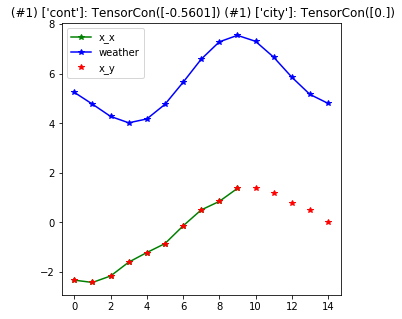

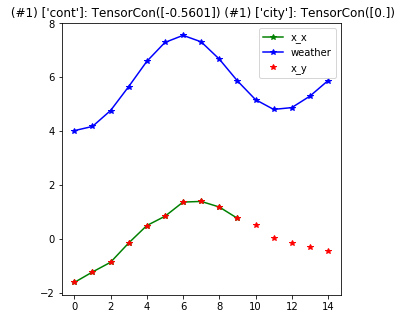

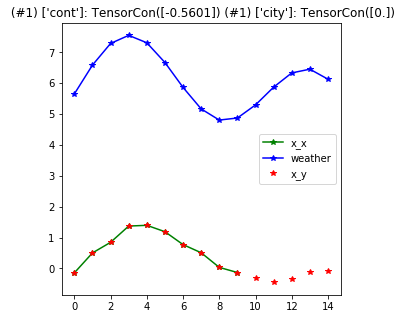

In [237]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3)
dl.show_batch(max_n=3)

In [ ]:
# hide
from nbdev.export import *

notebook2script()